## 5. Cohort Analysis

### 5.1 Prepare Cohort Data

In [30]:
print('--- Starting Cohort Analysis ---')
df_purchases = df[df['is_purchase'] == 1].copy()
df_purchases['purchase_day'] = df_purchases['event_time'].dt.to_period('D')
df_purchases['acquisition_day'] = df_purchases.groupby('user_id')['event_time'].transform('min').dt.to_period('D')

cohort_data = df_purchases.groupby(['acquisition_day','purchase_day']).agg(n_customers = ('user_id','nunique')).reset_index()

cohort_data['cohort_index'] = (cohort_data['purchase_day'] - cohort_data['acquisition_day'])
cohort_data['cohort_index'] = cohort_data['cohort_index'].apply(lambda x: x.n)

cohort_pivot = cohort_data.pivot_table(
    index = 'acquisition_day',
    columns = 'cohort_index',
    values = 'n_customers'
)
cohort_size = cohort_pivot.iloc[:,0]
retention_matrix = cohort_pivot.divide(cohort_size, axis = 0)
print("--- Cohort Data Prepared ---")

--- Starting Cohort Analysis ---
--- Cohort Data Prepared ---


### 5.2 Visualize Daily Retention Heatmap

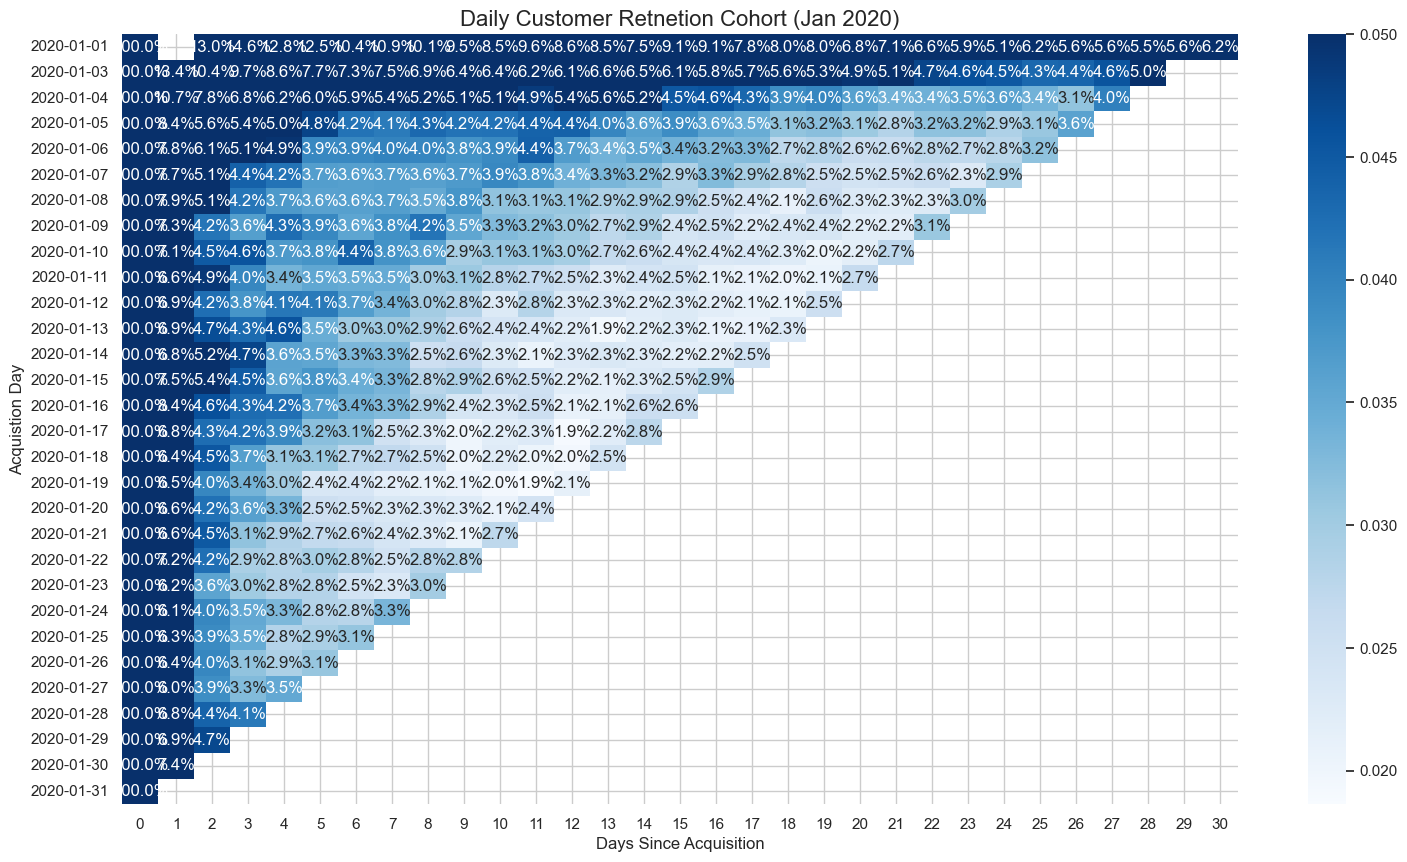

In [31]:
plt.figure(figsize =(18,10))
sns.heatmap(
    retention_matrix,
    annot = True,
    fmt = '.1%',
    cmap = 'Blues',
    vmax = 0.05
)
plt.title('Daily Customer Retnetion Cohort (Jan 2020)', fontsize = 16)
plt.ylabel('Acquistion Day')
plt.xlabel('Days Since Acquisition')
plt.show()

### Cohort Analysis Insight
- This section tracks groups of users over time to measure customer retention and loyalty.

- A "cohort" was defined as a group of users who made their first-ever purchase on the same day (acquisition_day).

- It then pivoted the data to see how many of these users from each cohort returned to make another purchase on subsequent days (Day 1, Day 2, Day 3, etc.).

- A retention matrix was calculated by dividing the number of returning users by the original size of the cohort.

- Visualization (Code): The analysis generated a sns.heatmap of this retention matrix.

#### Key Findings (from code output):

- The heatmap shows the percentage of each cohort that returned on a given day after their first purchase.

- The vmax was set to 0.05 (5%), indicating that retention rates are generally low, with the highest retention (outside of Day 0) being in the 1-5% range for the first few days, and dropping off after that.

## 6. Data Modeling 

### 6.1 Engineer Features at User-Level

In [32]:
print('--- Predictive Modeling ---')
print('Creating User-Level Features for Modeling')
user_features = df.groupby('user_id').agg(
    total_views = ('is_view','sum'),
    total_carts = ('is_cart','sum'),
    total_purchases = ('is_purchase', 'sum'),
    total_revenue = ('revenue','sum'),
    unique_sessions = ('user_session', 'nunique')
)
df_views = df[df['is_view'] == 1]
df_carts = df[df['is_cart'] == 1]

view_stats = df_views.groupby('user_id').agg(
    avg_price_of_viewed_items = ('price', 'mean'),
    unique_categories_viewed = ('category_l1','nunique' ),
    unique_brands_viewed = ('brand', 'nunique')
)

cart_stats = df_carts.groupby('user_id').agg(
    avg_price_carted_items = ('price','sum'),
    unique_categories_carted = ('category_l1','nunique'),
    unique_brands_carted = ('brand','nunique')
)

# Combine All Features

user_features = user_features.join(view_stats).join(cart_stats).fillna(0)                
user_features['view_to_cart_ratio'] = user_features['total_carts'] / user_features['total_views']

# Handle Division by 0 for User with 0 Views
user_features['view_to_cart_ratio'] = user_features['view_to_cart_ratio'].fillna(0).replace([np.inf, -np.inf], 0)

# Define Target Varible
user_features['target'] = (user_features['total_purchases'] > 0).astype(int)


print(f'Created featuers for {len(user_features)} unique_users')
print(f"Purchase Rate: {user_features['target'].mean():.2%}")

--- Predictive Modeling ---
Creating User-Level Features for Modeling
Created featuers for 4385985 unique_users
Purchase Rate: 8.19%


### 6.2 Train-Test Split & Scaling

In [33]:
print('--- Splitting & Scaling Data for Model ---')
feature_list = ['total_views', 
                'total_carts',
                'unique_sessions',
                'avg_price_of_viewed_items',
                'unique_categories_viewed',
                'avg_price_carted_items',
                'unique_categories_carted',
                'unique_brands_carted',
                'view_to_cart_ratio'
               ]

missing_cols = [c for c in feature_list if c not in user_features.columns]
if missing_cols:
    raise KeyError(f"Missing expected feature columns: {missing_cols}")

    
# 1. Train/Test Split 
X = user_features[feature_list]
y = user_features['target']


# Check dtypes and coerce numeric columns (if some are strings of numbers)
for c in X.columns:
    if not pd.api.types.is_numeric_dtype(X[c]):
        try:
            X[c] = pd.to_numeric(X[c], errors='coerce')
            print(f"Coerced {c} -> numeric")
        except Exception:
            print(f"WARNING: column {c} is non-numeric and could not be coerced")

# Report missing values and impute simple strategy (median) for numeric features
nulls = X.isnull().sum()
if nulls.sum() > 0:
    print("Null counts (per feature):")
    print(nulls[nulls>0])
    # quick, defensible imputation for a baseline
    X = X.fillna(X.median())
    
X_train, X_test, y_train, y_test = train_test_split(
    X,y,test_size = 0.2,random_state = 42,stratify = y
)
print("Train/Test Shapes:", X_train.shape, X_test.shape, y_train.value_counts(normalize = True).to_dict())

# 2. Baseline Classifier
dummy = DummyClassifier(strategy = 'most_frequent')
dummy.fit(X_train, y_train)
dummy_proba = dummy.predict_proba(X_test)[:,1] if hasattr(dummy, "predict_proba") else None
print("Baseline (most frequent) - if predict_proba available, ROC-AUC: ",
      roc_auc_score(y_test, dummy_proba) if dummy_proba is not None else "N/A")


--- Splitting & Scaling Data for Model ---
Train/Test Shapes: (3508788, 9) (877197, 9) {0: 0.9181244349900878, 1: 0.08187556500991225}
Baseline (most frequent) - if predict_proba available, ROC-AUC:  0.5


### 6.3 Pipeline + GridSearchCV

In [34]:
pipe = Pipeline([
    ('clf', RandomForestClassifier(random_state=42, n_jobs=-1, class_weight='balanced'))
])
param_grid = {
    'clf__n_estimators': [100, 200],
    'clf__max_depth': [None, 10],
    'clf__min_samples_leaf': [1, 5]
}

cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
search = GridSearchCV(pipe, param_grid, cv=cv, scoring='roc_auc', n_jobs = 1, verbose = 1)
search.fit(X_train, y_train)

print("Best params:", search.best_params_)
best_model = search.best_estimator_

Fitting 4 folds for each of 8 candidates, totalling 32 fits
Best params: {'clf__max_depth': 10, 'clf__min_samples_leaf': 5, 'clf__n_estimators': 200}


In [35]:
joblib.dump(best_model, "best_randomforest_model.pkl")

['best_randomforest_model.pkl']

### 6.4 Evaluate Model Performance

In [36]:
y_proba = best_model.predict_proba(X_test)[:,1]
roc = roc_auc_score(y_test, y_proba)
ap = average_precision_score(y_test, y_proba)
print(f"Test ROC-AUC: {roc:.4f}")
print(f"Test Average Precision (PR-AUC): {ap:.4f}")

# 5.Precision-Recall Curve 
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

Test ROC-AUC: 0.9741
Test Average Precision (PR-AUC): 0.7381


### 6.5 Plot PR Curve

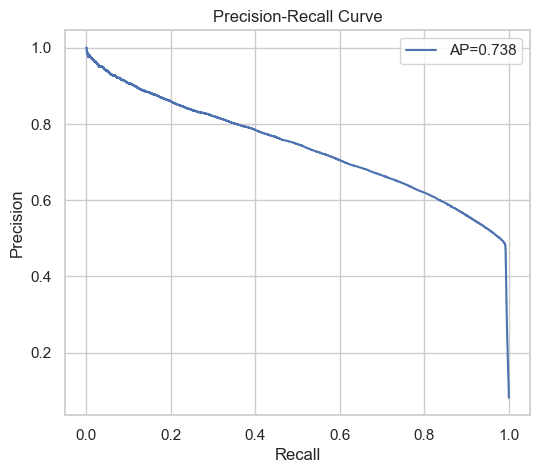

Best threshold from grid: 0.860  F1: 0.700


In [37]:
# 4) Plot PR curve
plt.figure(figsize=(6,5))
plt.plot(recall, precision, label=f'AP={ap:.3f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.legend()
plt.show()


th_grid = np.linspace(0.0, 1.0, 101)
f1_grid = []
for t in th_grid:
    pred = (y_proba >= t).astype(int)
    f1_grid.append(f1_score(y_test, pred))

best_idx = int(np.argmax(f1_grid))
best_threshold = float(th_grid[best_idx])
print(f"Best threshold from grid: {best_threshold:.3f}  F1: {f1_grid[best_idx]:.3f}")

chosen_threshold = best_threshold

### 6.6 Confusion Matrix at Threshold

Confusion Matrix (rows: true, cols: pred):
 [[767016  38360]
 [ 12536  59285]]

Classification Report at chosen threshold:
               precision    recall  f1-score   support

           0      0.984     0.952     0.968    805376
           1      0.607     0.825     0.700     71821

    accuracy                          0.942    877197
   macro avg      0.796     0.889     0.834    877197
weighted avg      0.953     0.942     0.946    877197



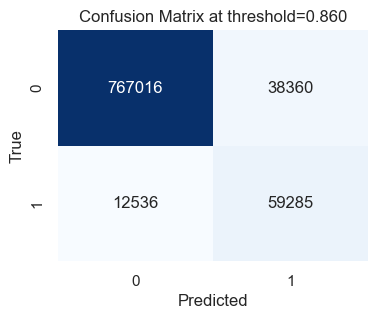

In [38]:
y_preds_thresh = (y_proba >= chosen_threshold).astype(int)
cm = confusion_matrix(y_test, y_preds_thresh)
print("Confusion Matrix (rows: true, cols: pred):\n", cm)
print("\nClassification Report at chosen threshold:\n", classification_report(y_test, y_preds_thresh, digits=3))

# plot confusion matrix
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix at threshold={chosen_threshold:.3f}')
plt.show()

### 6.7 Feature Importance

Top 10 features by importance:
 view_to_cart_ratio           0.333832
unique_brands_carted         0.206192
unique_categories_carted     0.202388
total_carts                  0.167637
avg_price_carted_items       0.072801
total_views                  0.009403
unique_sessions              0.005429
avg_price_of_viewed_items    0.001404
unique_categories_viewed     0.000915
dtype: float64


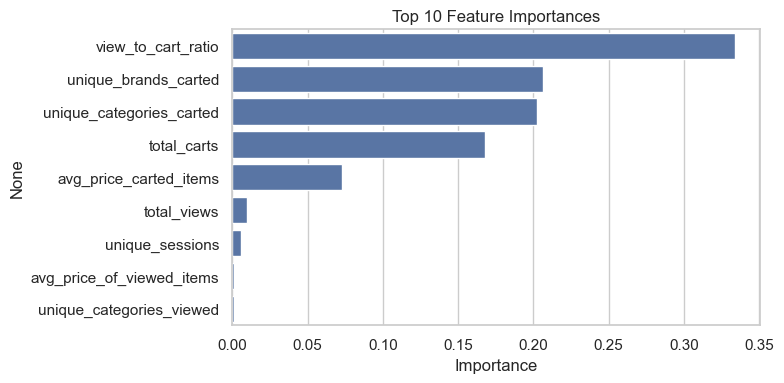

In [39]:
rf = best_model.named_steps['clf']
importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
print("Top 10 features by importance:\n", importances.head(10))

plt.figure(figsize=(8,4))
sns.barplot(x=importances.head(10).values, y=importances.head(10).index)
plt.title("Top 10 Feature Importances")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

## Predictive Modeling
- This section builds a machine learning model to predict whether a user will make a purchase.

#### Objective: 
- Predict if a user will ever make a purchase (target = 1) or not (target = 0) based on their aggregated behavior.

### Feature Engineering
Code: Instead of looking at single events, the data was aggregated for each of the 4.38 million unique users.

- Features Created:
total_views, total_carts, total_purchases
avg_price_of_viewed_items, avg_price_carted_items
unique_sessions, unique_categories_viewed, unique_brands_carted
view_to_cart_ratio (total_carts / total_views)

#### Dataset:
- Total Users: 4,385,985

- Purchase Rate (Class Balance): 8.19% of users made a purchase.


### Modeling & Evaluation
- Model: A RandomForestClassifier was chosen, placed within a Scikit-learn Pipeline.
- Tuning: GridSearchCV was used to find the best model parameters, optimizing for roc_auc (a good metric for imbalanced data).
- Best Parameters (from code output): {'max_depth': 10, 'min_samples_leaf': 5, 'n_estimators': 200}

#### Model Performance (from code output):
- Test ROC-AUC: 0.9741 (This is an excellent score, showing the model is very good at distinguishing between purchasers and non-purchasers).
- Test Average Precision (PR-AUC): 0.7381 (This is also a strong score, and more informative than ROC-AUC for imbalanced data).

### Classification Report:
- The model was tuned to find the best F1-score, which occurred at a probability threshold of 0.860.
- At this threshold, the model achieved an F1-score of 0.700 for the positive (purchase) class.
- Precision (Purchase Class): 0.607 (When it predicts a purchase, it's correct 60.7% of the time).
- Recall (Purchase Class): 0.825 (It successfully finds 82.5% of all actual purchasers).

### Feature Importance
- Code: The feature importances were extracted from the best RandomForestClassifier.

#### Key Findings (from code output): The model's predictions are overwhelmingly driven by carting behavior.
- view_to_cart_ratio: 33.4% importance
- unique_brands_carted: 20.6% importance
- unique_categories_carted: 20.2% importance
- total_carts: 16.8% importance
- avg_price_carted_items: 7.3% importance

### Conclusion: 
The strongest predictor of a future purchase is a user's past engagement with the cart. Users who add many different items, brands, and categories to their cart, and who have a high view-to-cart ratio, are a strong signal of purchase intent.